# AUTOMATED MARK CORRECTION SYSTEM

## INSTALLS AND IMPORTS

In [15]:
from IPython import display  # For clearing output

In [16]:
# Dependency to run the MSDM Model
!pip install ultralytics roboflow opencv-python
display.clear_output()

In [17]:
# base imports for imaging and handling dataframes
import cv2
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import numpy as np

# for loading MSDM Model
from ultralytics import YOLO

# for digit recognition model
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras import optimizers

## LOADING MODELS AND TEST IMAGE


In [18]:
MSDM_model = YOLO("MSDM_v1.pt")

HNGM_model = keras.models.load_model('HNGM_v2.keras',compile=False)
HNGM_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
test_img = "test.jpg"

## MSDM PREDICTION

In [56]:
# Predicting results

img = cv2.imread(test_img) # Reading image
img_resized = cv2.resize(img,(640,640)) # reszing to match training size

results = MSDM_model(img_resized)# prediction the bounds


0: 640x640 1 10b, 1 10d, 1 10e, 1 1c, 1 1e, 1 2a, 1 2b, 1 2d, 1 3b, 1 4a, 1 4c, 1 4d, 1 4e, 1 5c, 1 6b, 1 6c, 1 6e, 1 7a, 1 7b, 1 7d, 1 8c, 1 9a, 1 9d, 1 9e, 1 USN, 1549.8ms
Speed: 6.1ms preprocess, 1549.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


In [57]:
def plot_detections(image_path, results):
    image = cv2.imread(image_path)  # Reading image
    image = cv2.resize(image, (640, 640))  # Resize to match training size
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Get bounding box coordinates
            conf = box.conf[0].item()  # Get confidence score
            label = r.names[int(box.cls[0])]  # Get class label

            # Draw bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, f"{label} {conf:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Show Image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

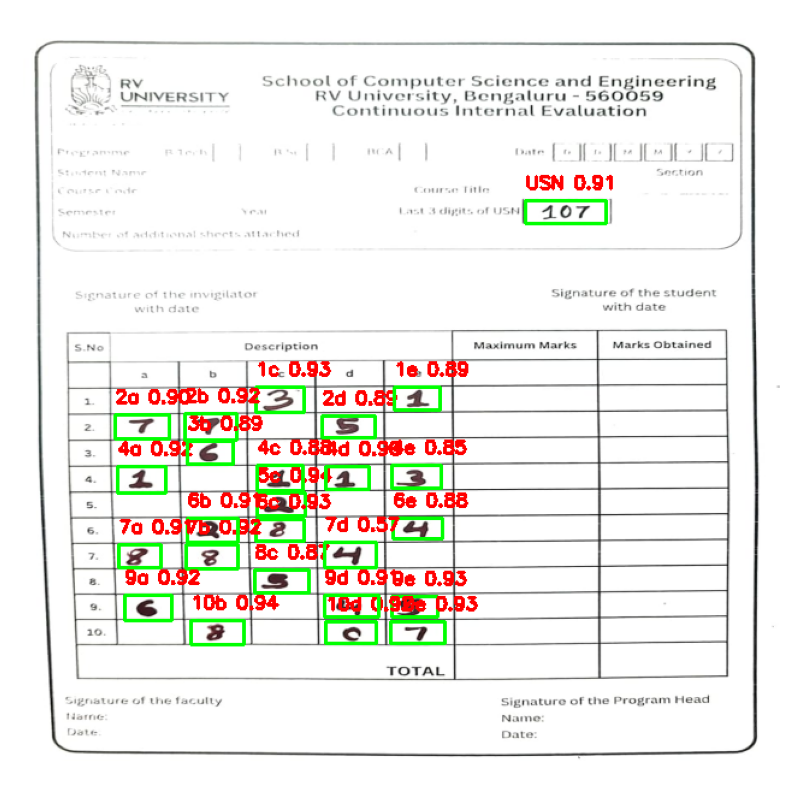

In [58]:
#displaying prediction
plot_detections(test_img, results)

## HNGM PREDICTION

In [59]:
#Global variables

detected_data = {}
processed_images = []
USN = []
titles = []
image_pixels = pd.DataFrame(columns=range(784)).add_prefix('pixels_')

In [44]:
def preprocess_digit(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold: white digits on black
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.zeros((28, 28), dtype=np.uint8)

    # Get largest contour
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    digit = thresh[y:y+h, x:x+w]

    # Resize to 18x18
    digit_resized = cv2.resize(digit, (18, 18), interpolation=cv2.INTER_AREA)

    # Create white 28x28 canvas and center digit
    canvas = np.full((28, 28), 255, dtype=np.uint8)
    x_offset = (28 - 18) // 2
    y_offset = (28 - 18) // 2
    canvas[y_offset:y_offset+18, x_offset:x_offset+18] = digit_resized

    # Brighten digit
    # Stretch pixel intensities: multiply all non-zero pixels
    canvas = canvas.astype(np.uint8)
    canvas = cv2.normalize(canvas, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Sharpen image
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    canvas = cv2.filter2D(canvas, -1, kernel)

    # Invert for model (white digit on black if needed)
    return 255 - canvas

In [45]:
def process_usn_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Normalize grayscale
    gray = gray.astype(np.uint8)
    gray = cv2.normalize(gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # === Sharpen image ===
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(gray, -1, kernel)

    return sharpened

In [46]:
def handle_detections(results, image):
    for r in results:
        boxes = r.boxes
        names = r.names

        for box in boxes:
            class_id = int(box.cls.item())
            class_name = names[class_id]

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cropped = image[y1:y2, x1:x2]

            if class_name != "USN":
                # Preprocess
                processed = preprocess_digit(cropped)

                # Store image and label
                processed_images.append(processed)
                titles.append(class_name)

                # Flatten and add to dataframe
                image_flat = processed.reshape(-1)
                image_pixels.loc[len(image_pixels)] = image_flat
            else:
                # USN specific handling
                usn_img = process_usn_image(cropped)
                USN.append(usn_img)

In [60]:
img = cv2.imread("test.jpg")
img = cv2.resize(img, (640, 640))

#taking the bounded images and converting them into a numpy array
handle_detections(results, img)

#printing the detected
print(image_pixels.shape)
print(image_pixels.head())

(24, 784)
   pixels_0  pixels_1  pixels_2  pixels_3  pixels_4  pixels_5  pixels_6  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   pixels_7  pixels_8  pixels_9  ...  pixels_774  pixels_775  pixels_776  \
0         0         0         0  ...           0           0           0   
1         0         0         0  ...           0           0           0   
2         0         0         0  ...           0           0           0   
3         0         0         0  ...           0           0           0   
4         0         0         0  ...           0           0           0   

   pixels_777  pixels_778  pixels_779  pixels_780  pixels_781  pixels_782  \
0    

In [61]:
#normalize the data
image_pixels = image_pixels.to_numpy().reshape(-1, 28, 28, 1)
image_pixels = (image_pixels.astype('float32'))/ 255

#### DETECTING SCORE VALUES

In [62]:
#predicting the model
predictions = HNGM_model.predict(image_pixels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


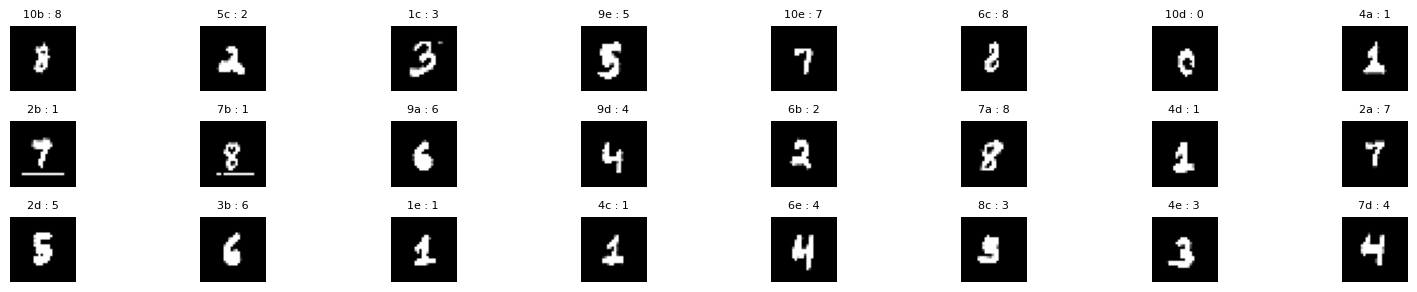

In [63]:
# Plotting the prediction in a grid

pred_df = pd.DataFrame(predictions, columns=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
pred_df = pd.DataFrame(pred_df.idxmax(axis=1))
pred_df.index.name = 'ImageId'
pred_df = pred_df.rename(columns={0: 'Label'}).reset_index()
pred_df['ImageId'] = pred_df['ImageId'] + 1

import math
n = len(processed_images)
cols = 8
rows = math.ceil(n / cols)

plt.figure(figsize=(cols * 2, rows))  # Adjust figure size for tight layout
for i in range(min(n, len(pred_df))):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(processed_images[i], cmap='gray')
    plt.title(f"{titles[i]} : {pred_df['Label'][i]}", fontsize=8)
    plt.axis('off')

plt.tight_layout(pad=1)
plt.show()

#### DETECTING USN

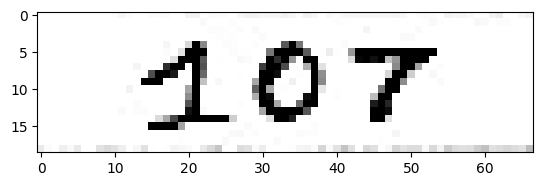

In [64]:
#printing the image
USN_gray = USN[0].reshape(USN[0].shape[0], USN[0].shape[1])

plt.imshow(USN_gray, cmap="gray")
plt.show()

### Getting Bounding baoxes of USN

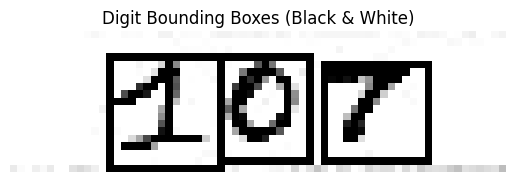

In [65]:

# Invert image (black digits on white)
_, thresh = cv2.threshold(USN_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Dilation to emphasize digits
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
dilated = cv2.dilate(thresh, kernel, iterations=1)

# Find contours (include nested ones just in case)
contours, hierarchy = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes with padding
padding = 1
bounding_boxes = []

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 3 and h > 8:  # Loosened size constraints
        x_pad = max(x - padding, 0)
        y_pad = max(y - padding, 0)
        w_pad = min(w + 2 * padding, USN_gray.shape[1] - x_pad)
        h_pad = min(h + 2 * padding, USN_gray.shape[0] - y_pad)
        bounding_boxes.append((x_pad, y_pad, w_pad, h_pad))

# Sort boxes left to right
bounding_boxes = sorted(bounding_boxes, key=lambda b: b[0])

# Create a copy for black-and-white visualization
img_copy = USN_gray.copy()

# Draw bounding boxes as white rectangles on grayscale image
for (x, y, w, h) in bounding_boxes:
    cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0), 1)  # white outline

# Show the final black-and-white image
plt.imshow(img_copy, cmap='gray')
plt.title("Digit Bounding Boxes (Black & White)")
plt.axis('off')
plt.show()

### Predicting the USN

In [66]:
pred_USN  = ""

for (x, y, w, h) in bounding_boxes:
  digit = USN_gray[y:y+h, x:x+w]
  digit = cv2.resize(digit, (28, 28), interpolation=cv2.INTER_AREA)
  digit = 255 - digit #invert

  reshaped = digit.reshape(1, 28, 28, 1)
  reshaped = reshaped.astype(np.float32) /255

  pred = HNGM_model.predict(reshaped)
  pred = np.argmax(pred)

  #for checking if bounded images are correct
  #plt.imshow(digit, cmap='gray')
  #plt.title(f"pred: {pred}")
  #plt.axis('off')
  #plt.show()

  pred_USN += str(pred)

print("Pred USN: ", pred_USN)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Pred USN:  107
